Train set - Total images: 4165


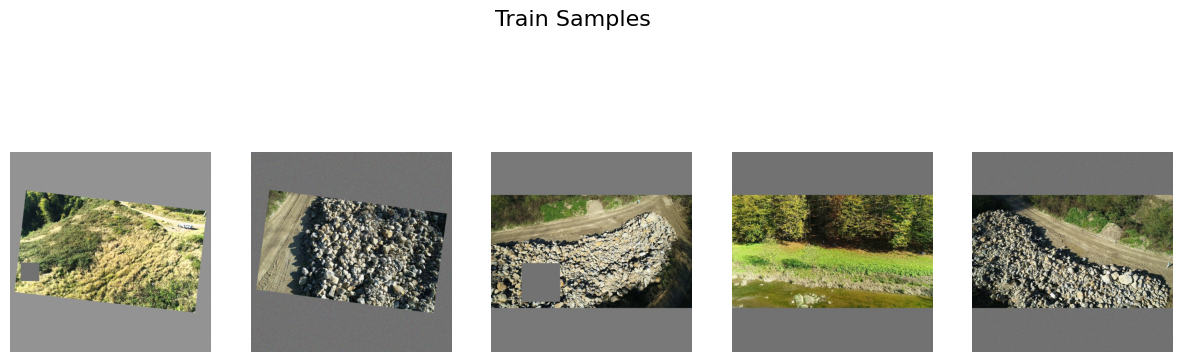

Valid set - Total images: 396


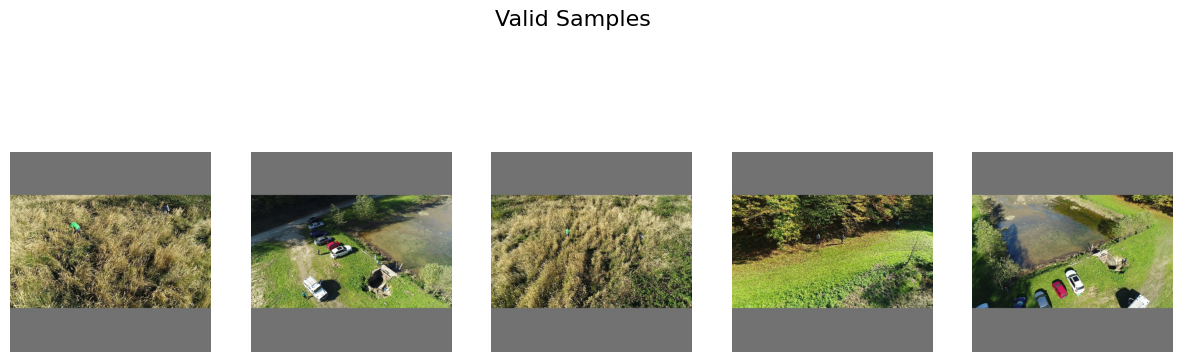

Test set - Total images: 198


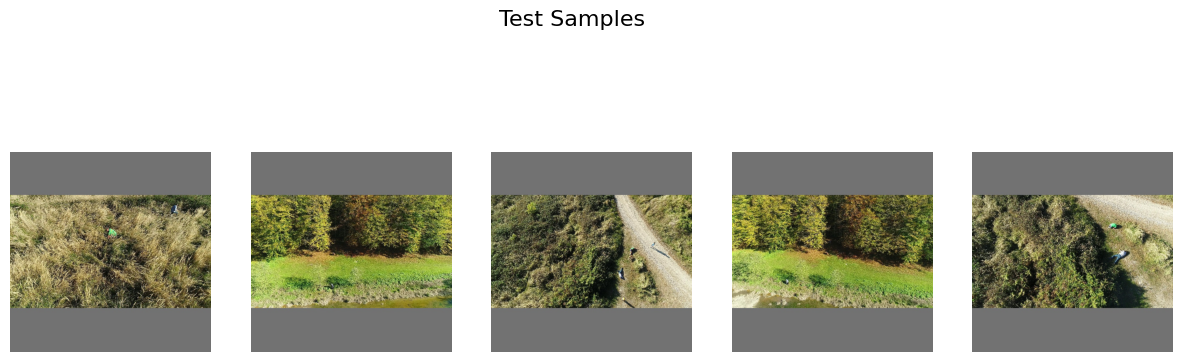

In [1]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Base path to the dataset in Kaggle
base_path = "/kaggle/input/sard-preprocessed/sard_preprocessed"

# Folders to process
folders = ["train", "valid", "test"]

def get_images_from_folder(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    images = get_images_from_folder(folder_path)
    
    print(f"{folder.capitalize()} set - Total images: {len(images)}")
    
    # Pick up to 5 random images
    sample_images = random.sample(images, min(5, len(images)))
    
    # Display images
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{folder.capitalize()} Samples", fontsize=16)
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, len(sample_images), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


Class Labels: ['Running', 'Walking', 'laying_down', 'not_defined', 'seated', 'stands']


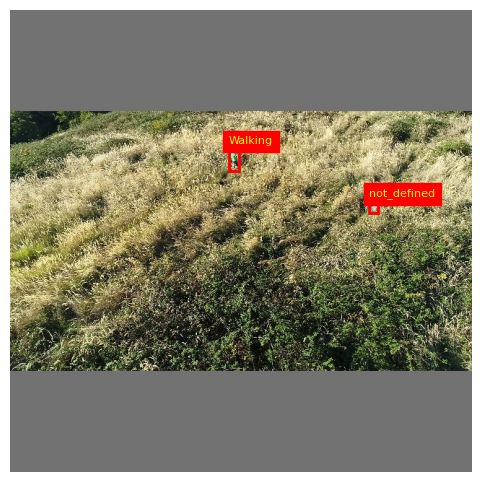

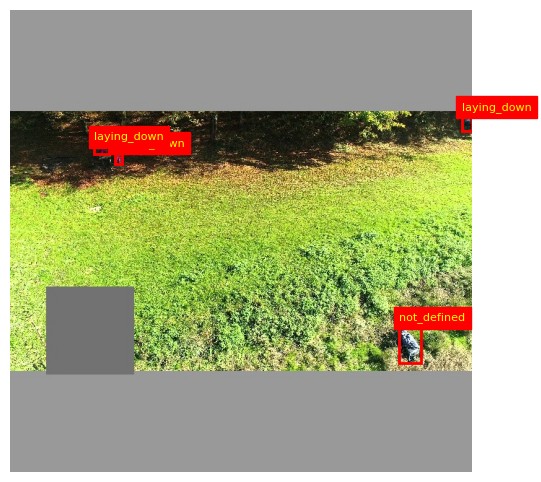

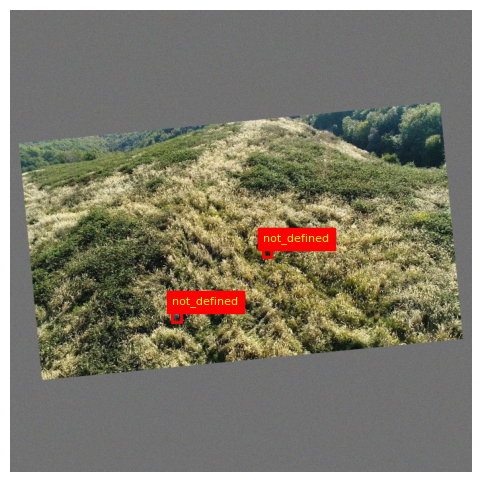

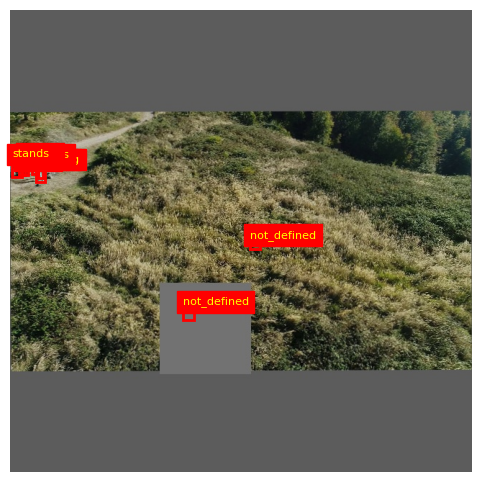

In [2]:
import os
import yaml
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Dataset base path in Kaggle
base_path = "/kaggle/input/sard-preprocessed/sard_preprocessed"

# Step 1: Load class labels from data.yaml
yaml_path = os.path.join(base_path, "data.yaml")
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

class_labels = data_yaml["names"]
print("Class Labels:", class_labels)

# Function to read YOLO labels
def load_yolo_labels(label_path, img_width, img_height):
    boxes = []
    with open(label_path, "r") as f:
        for line in f:
            cls, x_center, y_center, w, h = map(float, line.strip().split())
            cls = int(cls)
            # Convert YOLO format to pixel coordinates
            x_center *= img_width
            y_center *= img_height
            w *= img_width
            h *= img_height
            x_min = x_center - w / 2
            y_min = y_center - h / 2
            boxes.append((cls, x_min, y_min, w, h))
    return boxes

# Step 2 & 3: Display images with bounding boxes
def show_images_with_boxes(folder, num_samples=3):
    image_dir = os.path.join(base_path, folder, "images")
    label_dir = os.path.join(base_path, folder, "labels")
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    for img_file in sample_images:
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + ".txt")
        
        img = Image.open(img_path)
        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.imshow(img)
        
        if os.path.exists(label_path):
            boxes = load_yolo_labels(label_path, *img.size)
            for cls, x_min, y_min, w, h in boxes:
                rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(
                    x_min, y_min - 8,  # position a little above the box
                    class_labels[cls],
                    color='yellow',
                    fontsize=8,  # smaller font
                    backgroundcolor="red"
                )
        
        ax.axis('off')
        plt.show()

# Example: show samples from train set
show_images_with_boxes("train", num_samples=4)


In [3]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
from tqdm import tqdm
import shutil

# Base dataset path
base_path = "/kaggle/input/sard-preprocessed/sard_preprocessed"
output_path = "/kaggle/working/sard_harmonized"

# Make sure output directory exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)
shutil.copytree(base_path, output_path)

# Target image size
TARGET_SIZE = (640, 640)

# Function to harmonize a single image
def harmonize_image(img):
    # Resize
    img = img.resize(TARGET_SIZE)

    # Convert to OpenCV for further processing
    img_cv = np.array(img)

    # Equalize lighting (convert to LAB color space)
    lab = cv2.cvtColor(img_cv, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge((l, a, b))
    img_cv = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Convert back to PIL for saving
    img_pil = Image.fromarray(img_cv)
    return img_pil

# Loop through train/valid/test and harmonize images
for split in ["train", "valid", "test"]:
    img_dir = os.path.join(output_path, split, "images")
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    print(f"Harmonizing {split} images...")
    for img_file in tqdm(img_files):
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path).convert("RGB")
        img_h = harmonize_image(img)
        img_h.save(img_path)

print("✅ Harmonization complete. Dataset saved at:", output_path)


Harmonizing train images...


100%|██████████| 4165/4165 [01:10<00:00, 59.01it/s]


Harmonizing valid images...


100%|██████████| 396/396 [00:04<00:00, 81.66it/s]


Harmonizing test images...


100%|██████████| 198/198 [00:02<00:00, 82.11it/s]

✅ Harmonization complete. Dataset saved at: /kaggle/working/sard_harmonized


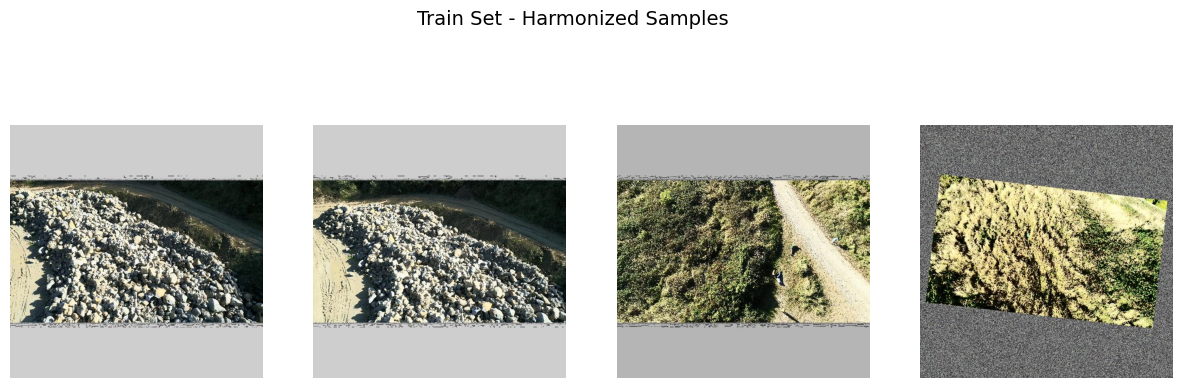

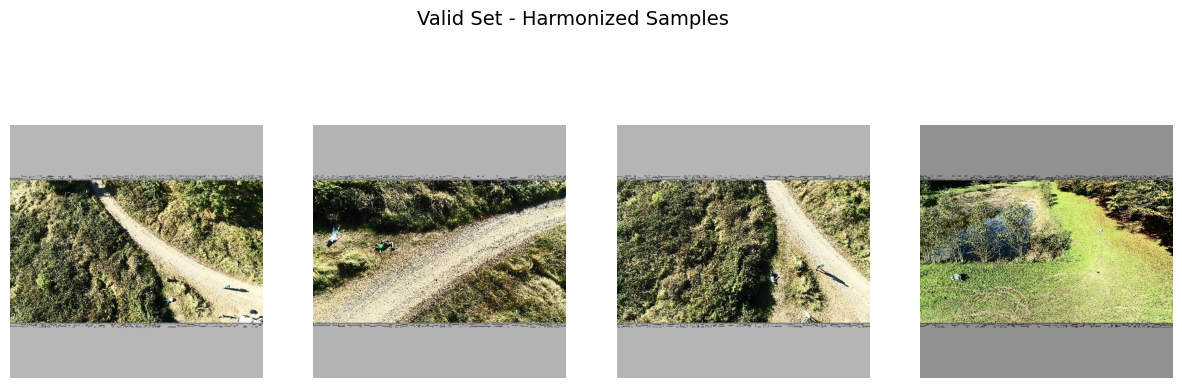

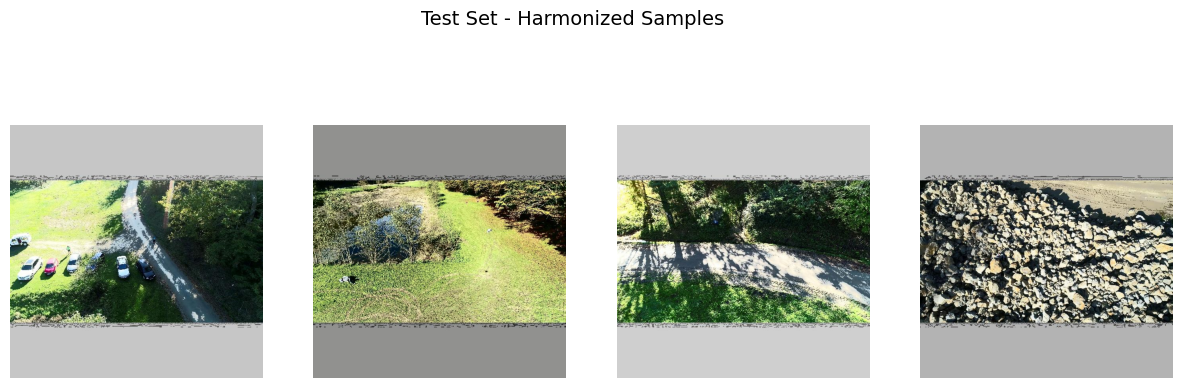

In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to harmonized dataset
harmonized_path = "/kaggle/working/sard_harmonized"

def show_harmonized_samples(split, num_samples=4):
    img_dir = os.path.join(harmonized_path, split, "images")
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    sample_images = random.sample(img_files, min(num_samples, len(img_files)))
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{split.capitalize()} Set - Harmonized Samples", fontsize=14)
    
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

# Show samples from each dataset split
for split in ["train", "valid", "test"]:
    show_harmonized_samples(split, num_samples=4)


In [5]:
import shutil

# Path to your harmonized dataset folder
folder_to_zip = "/kaggle/working/sard_harmonized"

# Path for the zip file
zip_path = "/kaggle/working/sard_harmonized.zip"

# Create a zip file of the folder
shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=folder_to_zip)

print(f"Dataset zipped at: {zip_path}")


Dataset zipped at: /kaggle/working/sard_harmonized.zip


In [6]:
!pip install --no-cache-dir ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 245.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 225.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 229.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 365.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 254.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 250.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 231.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 251.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 234.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 246.6 MB/s eta 0:00:00


In [7]:
from ultralytics import YOLO
import os

# Path to harmonized dataset's data.yaml inside the attached dataset (read-only)
data_yaml_path = "/kaggle/input/sard-harmonized/data.yaml"

# Load YOLOv8 model (medium variant)
model = YOLO("yolov8m.pt")

# Train the model
model.train(
    data=data_yaml_path,
    epochs=50,          # Increase if needed
    imgsz=640,
    batch=16,
    workers=4,
    device=0,           # Use GPU in Kaggle
    project="/kaggle/output/SARD_YOLOv8_Training",  # Save inside persistent output dir
    name="yolov8m_sard",
    exist_ok=True,
    save_period=1      # Save model every epoch
)

# Path where YOLOv8 saves models (persistent location)
save_dir = "/kaggle/output/SARD_YOLOv8_Training/yolov8m_sard"
print(f"✅ Training complete. Models saved in: {save_dir}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/sard-harmonized/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_sard, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 31.7±6.0 MB/s, size: 106.6 KB)


train: Scanning /kaggle/input/sard-harmonized/train/labels... 4165 images, 13 backgrounds, 0 corrupt: 100%|██████████| 4165/4165 [00:12<00:00, 345.11it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/sard-harmonized/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 28.5±10.5 MB/s, size: 126.7 KB)


val: Scanning /kaggle/input/sard-harmonized/valid/labels... 396 images, 2 backgrounds, 0 corrupt: 100%|██████████| 396/396 [00:01<00:00, 289.43it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/sard-harmonized/valid is not writeable, cache not saved.


Plotting labels to /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.16G      2.113      3.032       1.11         15        640: 100%|██████████| 261/261 [02:32<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


                   all        396       1312      0.565      0.268      0.278      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.36G      2.028       1.69      1.074         19        640: 100%|██████████| 261/261 [02:37<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.588      0.359      0.354      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.44G      1.997      1.572      1.064         19        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        396       1312      0.536       0.35      0.326      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.37G      1.944      1.468      1.047         14        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.476      0.417      0.426      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       6.3G      1.883      1.378      1.025         10        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


                   all        396       1312      0.718      0.435      0.491      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.41G      1.835      1.294      1.009         34        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        396       1312      0.573      0.495       0.53      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.37G      1.776      1.231     0.9903         26        640: 100%|██████████| 261/261 [02:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.578      0.471      0.535       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.39G      1.724      1.178     0.9792         27        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        396       1312      0.706      0.472       0.54      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.31G      1.663      1.115     0.9689         24        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.708      0.507      0.558      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.43G      1.658      1.074     0.9597         28        640: 100%|██████████| 261/261 [02:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.762      0.535      0.603      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       6.4G      1.602      1.023     0.9474         17        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312       0.63      0.537      0.634      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.37G       1.57     0.9815     0.9433         33        640: 100%|██████████| 261/261 [02:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        396       1312      0.585      0.571      0.622      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       6.3G      1.548     0.9614     0.9352         17        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


                   all        396       1312      0.646      0.615      0.643      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.39G      1.532     0.9425     0.9347         23        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.672      0.562      0.634      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.37G      1.496     0.9121     0.9253         11        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.606      0.645       0.64      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       6.4G       1.47     0.8769     0.9173         30        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.691      0.579      0.669      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.31G      1.454     0.8686     0.9165         13        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.706      0.593      0.661      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       6.4G      1.416     0.8223     0.9048         23        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.741      0.578      0.654      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.39G      1.405     0.8353     0.9024         20        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]

                   all        396       1312      0.663      0.625      0.656      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.39G      1.376     0.7963     0.9007         29        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.675      0.636      0.684      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       6.3G       1.36     0.7726     0.8971         34        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.635       0.66      0.693      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.41G      1.353     0.7717     0.8955         27        640: 100%|██████████| 261/261 [02:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


                   all        396       1312      0.699      0.627      0.688      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.4G       1.34     0.7591     0.8892         16        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        396       1312      0.777      0.633      0.694      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.38G      1.323     0.7344     0.8828         16        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.729      0.683      0.707      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.28G      1.301     0.7263     0.8821         11        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.735      0.669      0.728      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.39G      1.284     0.7102     0.8843         25        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.667        0.7      0.696      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       6.4G       1.26     0.6903     0.8755         23        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.718      0.714      0.728        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.39G      1.252     0.6812     0.8759         29        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.758      0.679      0.741       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.28G      1.234      0.666     0.8722         15        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.759      0.674       0.73      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.37G      1.208     0.6523     0.8703         23        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


                   all        396       1312      0.682      0.712      0.736      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.35G      1.192     0.6444     0.8684         23        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        396       1312      0.762        0.7      0.735      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.41G      1.186     0.6356     0.8662         19        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


                   all        396       1312      0.733      0.704      0.739      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.28G      1.181     0.6324     0.8628         24        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        396       1312      0.751      0.696      0.747      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.39G      1.159     0.6172     0.8598         18        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.743      0.729      0.754      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.41G      1.157     0.6088     0.8582         18        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.805      0.669      0.725      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       6.4G      1.138     0.6004     0.8554         26        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        396       1312      0.697      0.701      0.726      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.28G      1.121     0.5908     0.8508         30        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.789       0.69       0.75       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.42G      1.102     0.5723     0.8513         33        640: 100%|██████████| 261/261 [02:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        396       1312      0.831       0.68      0.747      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       6.4G      1.088     0.5601     0.8497         19        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]

                   all        396       1312      0.792      0.712      0.766      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.38G      1.078     0.5582     0.8501         23        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        396       1312      0.824      0.699      0.752      0.442


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.28G      1.042     0.5321     0.8538         15        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312      0.764      0.734      0.753      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.39G      1.018     0.5152     0.8509         11        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.812      0.707      0.755      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.38G     0.9958     0.4991     0.8459         19        640: 100%|██████████| 261/261 [02:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        396       1312      0.799      0.707      0.759      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.38G     0.9746     0.4912     0.8375         14        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.761      0.735       0.77      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.28G     0.9708     0.4842     0.8387         10        640: 100%|██████████| 261/261 [02:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


                   all        396       1312      0.802      0.705      0.752      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.4G     0.9451     0.4736     0.8353         15        640: 100%|██████████| 261/261 [02:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        396       1312       0.83      0.693      0.763      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.36G     0.9445     0.4733     0.8371         14        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        396       1312      0.786      0.723      0.765       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.35G     0.9165     0.4582     0.8299         14        640: 100%|██████████| 261/261 [02:36<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        396       1312      0.808      0.703      0.762       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.28G     0.8983      0.446     0.8266         17        640: 100%|██████████| 261/261 [02:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


                   all        396       1312      0.825        0.7      0.766      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.39G      0.895     0.4486     0.8309         11        640: 100%|██████████| 261/261 [02:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        396       1312      0.817      0.712      0.764      0.471



50 epochs completed in 2.289 hours.
Optimizer stripped from /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard/weights/best.pt, 52.0MB

Validating /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        396       1312      0.826        0.7      0.766      0.472
               Running         19         25      0.627       0.28      0.327      0.131
               Walking        146        266      0.772      0.636      0.769      0.427
           laying_down        226        322      0.956      0.957       0.98      0.718
           not_defined        144        189       0.87       0.73      0.809      0.454
                seated        133        138      0.956       0.92      0.955      0.647
                stands        191        372      0.777      0.674      0.756      0.457
Speed: 0.2ms preprocess, 12.2ms inference, 0.1ms loss, 2.2ms postprocess per image
Results saved to /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard
✅ Training complete. Models saved in: /kaggle/output/SARD_YOLOv8_Training/yolov8m_sard
